In [41]:
import odc.stac
import planetary_computer
import pystac_client
import stackstac
import rich.table
import xarray as xr
import pystac
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rx
import matplotlib.pyplot as plt
from xrspatial.zonal import stats
from rasterio.enums import Resampling
from dask.diagnostics import ProgressBar
import rasterio

In [42]:
rasterio.__version__

'1.3.7'

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40809,Workers: 4
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40781,Total threads: 1
Dashboard: /user/smuda@clarku.edu/proxy/39213/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:40675,


In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [7]:
bounding_box = [72, 32, 81, 38]

In [213]:
start_year = 2010
end_year = 2022

date_list = []

for year in range(start_year, end_year + 1):
    start_date = pd.to_datetime(f'{year}-05-01', utc=True)
    end_date = pd.to_datetime(f'{year}-08-31', utc=True)
    # start_date = pd.to_datetime(start_date)
    # end_date = pd.to_datetime(end_date)
    date_list.append((start_date, end_date))


In [9]:
geojson_path = '../india_states.geojson'
boundary = gpd.read_file(geojson_path)
ladakh = boundary.loc[boundary['ST_NM'] == 'Ladakh']

<Axes: >

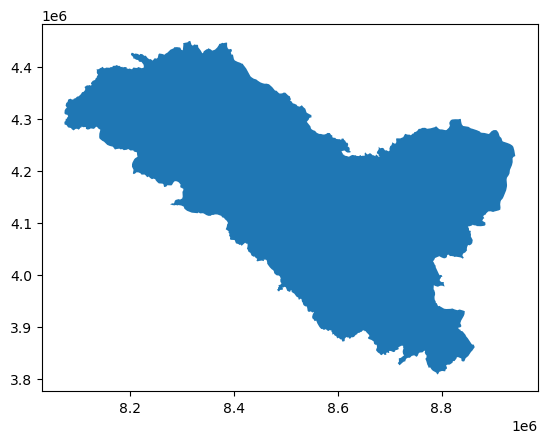

In [10]:
target_epsg_code = 3857  # web mercator
# Reproject the GeoDataFrame to the target PCS
ladakh_projected = ladakh.to_crs(epsg=target_epsg_code)
ladakh_geometry = ladakh_projected.geometry
ladakh_projected.plot()

In [ ]:
lad_geometry = ladakh_projected.__geo_interface__['features'][0]['geometry']

In [67]:
for datetime in date_list:
    search = catalog.search(
    collections=["modis-10A1-061"],
    bbox=bounding_box,
    #intersects=lad_geometry,
    datetime=date_list[0]
)
items2 = search.item_collection()
items2

id: MYD10A1.A2021243.h24v05.061.2021245052702
"bbox: [69.0408206779493, 29.8451444703661, 91.398292082842, 40.0539553679112]"
created: 2021-09-02T05:27:27Z
updated: 2021-09-01T23:34:13.265000Z
datetime: None
platform: aqua
proj:epsg: None
"proj:wkt2: PROJCS[""unnamed"",GEOGCS[""Unknown datum based upon the custom spheroid"",DATUM[""Not specified (based on custom spheroid)"",SPHEROID[""Custom spheroid"",6371007.181,0]],PRIMEM[""Greenwich"",0],UNIT[""degree"",0.0174532925199433,AUTHORITY[""EPSG"",""9122""]]],PROJECTION[""Sinusoidal""],PARAMETER[""longitude_of_center"",0],PARAMETER[""false_easting"",0],PARAMETER[""false_northing"",0],UNIT[""Meter"",1],AXIS[""Easting"",EAST],AXIS[""Northing"",NORTH]]"
"proj:shape: [2400, 2400]"
instruments: ['modis']
end_datetime: 2021-08-31T23:59:59Z


In [69]:
t = rich.table.Table("Key", "Title")
for key, asset in items2.items[0].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                                ┃ Title                                                                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf                                │ Source data containing all bands                                        │
│ NDSI                               │ Raw NDSI values (i.e. prior to screening).                              │
│ metadata                           │ Federal Geographic Data Committee (FGDC) Metadata                       │
│ orbit_pnt                          │ Pointer to the orbit of the swath mapped into each grid cell.           │
│ granule_pnt                        │ Pointer for identifying the swath mapped into each grid cell.           │
│ NDSI_Snow_Cover                    │ Gridded NDSI snow cover and data flag values.                           │
│ Snow_Albedo_Daily_Tile             │ Daily snow albedo corresponding to the NDSI_Snow_Cover parameter.       │
│ NDSI_Snow_Cover_Basic_QA           │ A general estimate of the quality of the algorithm result.              │
│ NDSI_Snow_Cover_Algorithm_Flags_QA │ Algorithm-specific bit flags set for data screens and for inland water. │
│ tilejson                           │ TileJSON with default rendering                                         │
│ rendered_preview                   │ Rendered preview                                                        │
└────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

In [19]:
data2 = odc.stac.load(
    items2,
    bands=['NDSI_Snow_Cover'],
    crs='EPSG:3857',
    bbox =bounding_box,
    #geopolygon = lad_geometry,
    resolution=500,
    chunks={'x':2048,'y':2048},
)
data2

<xarray.Dataset>
Dimensions:          (y: 1633, x: 2004, time: 123)
Coordinates:
  * y                (y) float64 4.579e+06 4.579e+06 ... 3.764e+06 3.763e+06
  * x                (x) float64 8.015e+06 8.016e+06 ... 9.016e+06 9.017e+06
    spatial_ref      int32 3857
  * time             (time) datetime64[ns] 2021-05-01 2021-05-02 ... 2021-08-31
Data variables:
    NDSI_Snow_Cover  (time, y, x) uint8 dask.array<chunksize=(1, 1633, 2004), meta=np.ndarray>

In [ ]:
modis_data = stackstac.stack(items2,['NDSI_Snow_Cover'], bounds_latlon=bounding_box, epsg=3857, resolution = 500)
modis_data

In [ ]:
sc_da = modis_data.sel(band="NDSI_Snow_Cover")

In [21]:
sc_da2 = data2['NDSI_Snow_Cover']

In [22]:
sc_da2

<xarray.DataArray 'NDSI_Snow_Cover' (time: 123, y: 1633, x: 2004)>
dask.array<NDSI_Snow_Cover, shape=(123, 1633, 2004), dtype=uint8, chunksize=(1, 1633, 2004), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.579e+06 4.579e+06 ... 3.764e+06 3.763e+06
  * x            (x) float64 8.015e+06 8.016e+06 ... 9.016e+06 9.017e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-05-01 2021-05-02 ... 2021-08-31

In [23]:
sc_clipped = sc_da2.rio.clip(ladakh_geometry, drop=True)


In [99]:
sc_clipped

<xarray.DataArray 'NDSI_Snow_Cover' (time: 123, y: 1284, x: 1736)>
dask.array<astype, shape=(123, 1284, 1736), dtype=uint8, chunksize=(1, 1284, 1736), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.45e+06 4.449e+06 ... 3.809e+06 3.808e+06
  * x            (x) float64 8.074e+06 8.075e+06 ... 8.941e+06 8.942e+06
  * time         (time) datetime64[ns] 2021-05-01 2021-05-02 ... 2021-08-31
    spatial_ref  int64 0

In [50]:
#sc_clipped.rio.write_crs("epsg:3857", inplace=True)
sc_clipped.rio.crs

CRS.from_epsg(3857)

In [115]:
with ProgressBar():
    print("The minimum raster value is: ", np.nanmax(binary_sc[0]))
# print("The maximum raster value is: ", np.nanmax(sc_clipped).compute())

[########################################] | 100% Completed | 34.64 s
The minimum raster value is:  1


In [100]:
sc_clipped = sc_clipped.where(sc_clipped <= 100)

In [130]:
monthly_mean_sc = sc_clipped.groupby('time.month').mean(dim='time')

In [131]:
binary_sc = xr.where(monthly_mean_sc >= 50, 1, 0)

In [132]:
binary_sc

<xarray.DataArray 'NDSI_Snow_Cover' (month: 4, y: 1284, x: 1736)>
dask.array<where, shape=(4, 1284, 1736), dtype=int64, chunksize=(1, 1284, 1736), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.45e+06 4.449e+06 ... 3.809e+06 3.808e+06
  * x            (x) float64 8.074e+06 8.075e+06 ... 8.941e+06 8.942e+06
    spatial_ref  int64 0
  * month        (month) int64 5 6 7 8

In [ ]:
#items = dict()

#     print(f"Fetching {datetime}")
#     search = catalog.search(
#         collections=["modis-10A1-061"],
#         bbox=bbox,
#         datetime=time_of_interest
#     )
#     items = search.item_collection()[0]
# items
def create_xarray(date_list, date = 0, data_array = None):
    temp = date
    if temp == len(date_list):
        return data_array
    # for datetime in date_list:
    search = catalog.search(
        collections=["modis-10A1-061"],
        bbox=bbox,
        datetime=date_list[temp]
    )
    items = search.item_collection()
    data = odc.stac.load(
        items,
        bands=['NDSI'],
        bbox=bbox,
        resolution=500,
        chunks={'x':2048,'y':2048},
        crs=4326
    )
    if data_array == None:
        temp+=1
        return create_xarray(date_list, temp, data)
    elif date == 2:
        return data_array
    else:
        data_array = xr.merge(data_array,data)
        temp+=1
        return create_xarray(date_list, temp, data_array)
    
# Combine the two collections
# combined_collection = items[0]
# for item_collection in items[1:]:
#     combined_collection += item_collection
    
# len(combined_collection.items)


In [ ]:
create_xarray(date_list)

In [72]:
monthly_mean_sc[0].rio.crs


CRS.from_epsg(3857)

In [ ]:
condition = monthly_mean_sc >= 50
binary_sc = condition.astype(float)

In [76]:
monthly_mean_sc[0].rio.bounds()

(8074000.0, 3808000.0, 8942000.0, 4450000.0)

In [73]:
srtm_90 = rx.open_rasterio('../SRTMGL3.tif', masked=True)

srtm_90 = srtm_90.rio.reproject_match(monthly_mean_sc[0], resampling = Resampling.bilinear)


In [74]:
srtm_90.rio.bounds()

(8074000.0, 3808000.0, 8942000.0, 4450000.0)

In [77]:
clipped_raster = srtm_90.rio.clip(ladakh_geometry, drop=True)
clipped_raster = clipped_raster.fillna(0)


In [79]:
# Defines the bins for pixel values
class_bins = (0, 3000, 4000, 5000, 6000, 9000)


dem_classified = xr.apply_ufunc(
    np.digitize,
    clipped_raster[0],
    class_bins,
    keep_attrs=True
)

In [154]:
np.max(dem_classified.data)

5.0

In [176]:
dem_classified = dem_classified.chunk({'x': 100, 'y': 100})


In [148]:
dem_classified = dem_classified.astype('float64')

In [193]:
type(dem_classified[0][0].data)

dask.array.core.Array

In [188]:
isinstance(dem_classified.data, type(sc_clipped[0].data))

True

In [222]:
binary_sc['month'].values[0]

5

In [223]:
zonal_stats_list = []
with ProgressBar():
    for month_index in range(len(binary_sc['month'])):
        # Select a single time slice
        binary_sc_month = binary_sc.isel(month=month_index)

        sc_stats = stats(
            zones=dem_classified,
            values=binary_sc_month,
            zone_ids=[2.0,3.0,4.0],
            stats_funcs=["sum"])
            .compute()
         # Store zonal statistics in the dictionary using the time as the key
        sc_stats['month'] = binary_sc['month'].values[month_index]
        zonal_stats_list.append(sc_stats)

        


[########################################] | 100% Completed | 12.11 s
[########################################] | 100% Completed | 11.47 s
[########################################] | 100% Completed | 12.53 s
[########################################] | 100% Completed | 11.84 s


In [228]:
stats_df = []
for stat in zonal_stats_list:
    stats_df.append(stat.compute())

In [230]:
# Concatenate the individual DataFrames into a single Pandas DataFrame
final_zonal_stats_df = pd.concat(stats_df, ignore_index=True)


In [231]:
final_zonal_stats_df

,zone,sum,month
0,2.0,216.0,5
1,3.0,6690.0,5
2,4.0,378.0,5
3,2.0,32.0,6
4,3.0,3205.0,6
5,4.0,1595.0,6
6,2.0,5.0,7
7,3.0,251.0,7
8,4.0,346.0,7
9,2.0,0.0,8
